In [113]:
import pandas as pd
import numpy as np


In [13]:
# Load datasets

df1 = pd.read_stata('/Users/jpmvbastos/Documents/GitHub/populism-sca/ARG_AVG.dta')
df2 = pd.read_stata('/Users/jpmvbastos/Documents/GitHub/populism-sca/BOL_AVG.dta')
df3 = pd.read_stata('/Users/jpmvbastos/Documents/GitHub/populism-sca/ECU_AVG.dta')
df4 = pd.read_stata('/Users/jpmvbastos/Documents/GitHub/populism-sca/NIC_AVG.dta')
df5 = pd.read_stata('/Users/jpmvbastos/Documents/GitHub/populism-sca/VEN_AVG.dta')

#Create identifier for each dataset
df1['group'] = 'Argentina'
df2['group'] = 'Bolivia'
df3['group'] = 'Ecuador'
df4['group'] = 'Nicaragua'
df5['group'] = 'Venezuela'

# Treatment year
t1 = 2003
t2 = 2006
t3 = 2007
t4 = 2007
t5 = 1998

# Replace year relative to treatment year
df1['time'] = df1['year'] - t1
df2['time'] = df2['year'] - t2
df3['time'] = df3['year'] - t3
df4['time'] = df4['year'] - t4
df5['time'] = df5['year'] - t5    

# Concatenate datasets
df = pd.concat([df1, df2, df3, df4, df5], axis=0)

# Select years from -10 to 10
df = df[(df['time'] >-11) & (df['time'] <11)] 

# Drop irrelevant columns
df = df.drop(['polity2', 'EFW','WGI1', 'WGI2', 'WGI3',
               'ICRG', 'VDEM1', 'VDEM2', 'VDEM3',
                'VDEM4', 'VDEM5', 'VDEM6'], axis=1)


In [14]:
df


,country,country_code,id,populist,year,VDEMy,pre_rmspe,post_rmspe,lead,effect,VDEMy_synth,group,time
3,Algeria,DZA,1,0,1993,8.100000,9.741844,18.506227,-9,-9.217600,17.317600,Argentina,-10
4,Algeria,DZA,1,0,1994,10.200000,9.741844,18.506227,-8,-3.312000,13.512000,Argentina,-9
5,Algeria,DZA,1,0,1995,11.400000,9.741844,18.506227,-7,-2.193601,13.593600,Argentina,-8
6,Algeria,DZA,1,0,1996,15.800000,9.741844,18.506227,-6,1.766400,14.033600,Argentina,-7
7,Algeria,DZA,1,0,1997,15.500000,9.741844,18.506227,-5,0.728800,14.771200,Argentina,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,Venezuela,VEN,32,1,2004,22.000000,1.120011,44.693062,6,-42.993301,64.993301,Venezuela,6
835,Venezuela,VEN,32,1,2005,18.299999,1.120011,44.693062,7,-47.012199,65.312195,Venezuela,7
836,Venezuela,VEN,32,1,2006,17.100000,1.120011,44.693062,8,-48.740101,65.840103,Venezuela,8
837,Venezuela,VEN,32,1,2007,16.700001,1.120011,44.693062,9,-49.352600,66.052597,Venezuela,9


## Calculating p-values

Our average treatment effect is calculated as follows: 
- We estimated synthetic counterfactuals to Argentina, Bolivia, Ecuador, Nicaragua, and Venezuela. 
- We averaged their actual VDEMy series and compared to the average of their synthetics. 
- For each post-treatment period, we have an effect size. 

To calculate p-values, we first need the placebos. 
- We do the same as above for any five donors.
- We randomly draw one donor from each sample and average the 5 draws.
- We average the synthetic counterfactual for each of these donors. 
- And again, we have an effect size for each of these placebos. 

Finally, we calculate the **Proportion of Placebo Effects Larger in Magnitude that our Treatment Effect**. 
If our Treatement Effect is on the Top 10% magnitude, it is significant. 

In [15]:
# Create a list of all possible combinations of countries, drawing one from each sample (with replacement)

from itertools import product

sets_list = []

for group in df.group.unique():
    sets_list.append(set(df.loc[(df['populist'] == 0) & (df['group']== group), 'country'].unique()))

combinations = list(product(*sets_list))

display('There are {} potential placebos'.format(len(combinations)))

'There are 14348907 potential placebos'

In [19]:
# Select a random draw of 10000 combinations
import random
random.seed(1234)
sample = random.sample(combinations, 10000)

In [21]:
dict = {1: 'Argentina', 2: 'Bolivia', 3: 'Ecuador', 4: 'Nicaragua', 5: 'Venezuela'}

data = df.loc[df['populist'] == 1].groupby('time')[['populist','VDEMy','VDEMy_synth']].mean().reset_index() # Average data

data['avg'] = 'Populists' # List of countries in average
data['id'] = 0 # Add id
data.set_index('id', inplace=True) # Set id as index

iterations = 0

for element in sample:
    iterations+=1 # Add iteration
    id = element # Set of countries
    print("Iteration " + str(iterations) + " of 10,000. Building average of countries:" + str(list(id)))
    d = pd.DataFrame(columns=df.columns)   
    for i in range(0,5):
        country, group = list(element)[i], dict[i+1]
        c = df.loc[(df['country'] == country) & (df['group'] == group)] # Select country and group
        d = pd.concat([d, c], axis=0) # Concatenate data
    
    avg = d.groupby('time')[['populist','VDEMy','VDEMy_synth']].mean().reset_index() # Average data
    avg['avg'] = str(id) # List of countries in average
    avg['id'] = iterations # Add id
    avg.set_index('id', inplace=True) # Set id as index

    data = pd.concat([data, avg], axis=0) # Concatenate data

display(data)
        

Iteration 1 of 10,000. Building average of countries:['Algeria', 'Belgium', 'Germany', 'Paraguay', 'Australia']
Iteration 2 of 10,000. Building average of countries:['Brazil', 'Algeria', 'Sweden', 'France', 'Paraguay']
Iteration 3 of 10,000. Building average of countries:['Austria', 'Sweden', 'United Kingdom', 'Nigeria', 'Australia']
Iteration 4 of 10,000. Building average of countries:['France', 'Turkey', 'Australia', 'Chile', 'Guatemala']
Iteration 5 of 10,000. Building average of countries:['Peru', 'Mexico', 'Germany', 'Guatemala', 'Thailand']
Iteration 6 of 10,000. Building average of countries:['Spain', 'Japan', 'Mexico', 'Costa Rica', 'Uruguay']
Iteration 7 of 10,000. Building average of countries:['Sweden', 'Australia', 'Germany', 'Australia', 'United Kingdom']
Iteration 8 of 10,000. Building average of countries:['Guatemala', 'Peru', 'Portugal', 'Denmark', 'Costa Rica']
Iteration 9 of 10,000. Building average of countries:['Denmark', 'Nigeria', 'Chile', 'Australia', 'France']
I

,time,populist,VDEMy,VDEMy_synth,avg
id,,,,,
0,-10,1.0,52.140003,51.501801,Populists
0,-9,1.0,52.779999,51.629181,Populists
0,-8,1.0,52.420002,51.687843,Populists
0,-7,1.0,52.520000,52.117699,Populists
0,-6,1.0,52.420002,52.203857,Populists
...,...,...,...,...,...
10000,6,0.0,69.659996,74.907974,"('Australia', 'Netherlands', 'Australia', 'Alg..."
10000,7,0.0,69.680008,74.614616,"('Australia', 'Netherlands', 'Australia', 'Alg..."
10000,8,0.0,70.139999,74.834099,"('Australia', 'Netherlands', 'Australia', 'Alg..."


In [35]:
data

,time,populist,VDEMy,VDEMy_synth,avg,gap
id,,,,,,
0,-10,1.0,52.140003,51.501801,Populists,0.638203
0,-9,1.0,52.779999,51.629181,Populists,1.150818
0,-8,1.0,52.420002,51.687843,Populists,0.732159
0,-7,1.0,52.520000,52.117699,Populists,0.402302
0,-6,1.0,52.420002,52.203857,Populists,0.216145
...,...,...,...,...,...,...
10000,6,0.0,69.659996,74.907974,"('Australia', 'Netherlands', 'Australia', 'Alg...",-5.247978
10000,7,0.0,69.680008,74.614616,"('Australia', 'Netherlands', 'Australia', 'Alg...",-4.934608
10000,8,0.0,70.139999,74.834099,"('Australia', 'Netherlands', 'Australia', 'Alg...",-4.694099


In [71]:
# Calculate effect gap 
data['gap'] = data['VDEMy'] - data['VDEMy_synth'] # Calculate gap

# Calculate pre and post RMSPE by id
data['gap2'] = data['gap']**2 # Calculate pre RMSPE

# Average pre and post RMSPE
data['premean']= data.loc[(data['time'] < 0)].groupby('id')['gap2'].mean() # Average pre RMSPE
data['postmean'] = data.loc[(data['time'] >= 0)].groupby('id')['gap2'].mean() # Average post RMSPE

# Create a single column with pre and post RMPSE
data['RMSPE'] = np.where(data['time'] < 0, np.sqrt(data['premean']), np.sqrt(data['postmean']))

#Calculate the ratio of post to pre RMSPE by id (joint p-value test for all post-treatment periods)
data['ratio'] = data.groupby('id')['postmean'].transform(np.sqrt) / data.groupby('id')['premean'].transform(np.sqrt)

# Calculate the ratio of effect to pre RMSPE by id (two-sided test)
data['ratio_two'] = np.abs(data['gap']) / data.groupby('id')['premean'].transform(np.sqrt)

# Calculate the ratio of effect to pre RMSPE by id (one-sided test)
data['ratio_one'] = data['gap'] / data.groupby('id')['premean'].transform(np.sqrt)

data


,time,populist,VDEMy,VDEMy_synth,avg,gap,gap2,premean,postmean,RMSPE,ratio,ratio_two,ratio_one
id,,,,,,,,,,,,,
0,-10,1.0,52.140003,51.501801,Populists,0.638203,0.407303,0.334068,454.018951,0.577986,36.865448,1.104183,1.104183
0,-9,1.0,52.779999,51.629181,Populists,1.150818,1.324382,0.334068,454.018951,0.577986,36.865448,1.991082,1.991082
0,-8,1.0,52.420002,51.687843,Populists,0.732159,0.536056,0.334068,454.018951,0.577986,36.865448,1.266741,1.266741
0,-7,1.0,52.520000,52.117699,Populists,0.402302,0.161847,0.334068,454.018951,0.577986,36.865448,0.696041,0.696041
0,-6,1.0,52.420002,52.203857,Populists,0.216145,0.046718,0.334068,454.018951,0.577986,36.865448,0.373961,0.373961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,6,0.0,69.659996,74.907974,"('Australia', 'Netherlands', 'Australia', 'Alg...",-5.247978,27.541275,6.898020,17.657837,4.202123,1.599950,1.998158,-1.998158
10000,7,0.0,69.680008,74.614616,"('Australia', 'Netherlands', 'Australia', 'Alg...",-4.934608,24.350361,6.898020,17.657837,4.202123,1.599950,1.878843,-1.878843
10000,8,0.0,70.139999,74.834099,"('Australia', 'Netherlands', 'Australia', 'Alg...",-4.694099,22.034569,6.898020,17.657837,4.202123,1.599950,1.787269,-1.787269


In [83]:
# Rank the effect sizes 

# Rank the ids by mean ratio 
data['rank'] = data.groupby('id')['ratio'].mean().rank(ascending=False) # Rank effect sizes

# Rank the ids by mean ratio_two
data['rank_two'] = data.groupby('time')['ratio_two'].rank(ascending=False) # Rank effect sizes

# Rank the ids by mean ratio_one
data['rank_one'] = data.groupby('time')['ratio_one'].rank(ascending=True) # Rank effect sizes


In [91]:
#Calculate p-values
data['joint_pval'] = (data['rank'] - 1) / 10000 # Joint p-value

data['onesided_pval'] = (data['rank_one'] - 1) / 10000 # One-sided p-value

data['twosided_pval'] = (data['rank_two'] - 1) / 10000 # One-sided p-value


In [92]:
data.head(21)

,time,populist,VDEMy,VDEMy_synth,avg,gap,gap2,premean,postmean,RMSPE,ratio,ratio_two,ratio_one,rank,rank_two,rank_one,joint_pval,onesided_pval,twosided_pval
id,,,,,,,,,,,,,,,,,,,
0,-10,1.0,52.140003,51.501801,Populists,0.638203,0.407303,0.334068,454.018951,0.577986,36.865448,1.104183,1.104183,1.0,3168.0,8493.0,0.0,0.8492,0.3167
0,-9,1.0,52.779999,51.629181,Populists,1.150818,1.324382,0.334068,454.018951,0.577986,36.865448,1.991082,1.991082,1.0,584.0,9757.0,0.0,0.9756,0.0583
0,-8,1.0,52.420002,51.687843,Populists,0.732159,0.536056,0.334068,454.018951,0.577986,36.865448,1.266741,1.266741,1.0,2982.0,8805.0,0.0,0.8804,0.2981
0,-7,1.0,52.520000,52.117699,Populists,0.402302,0.161847,0.334068,454.018951,0.577986,36.865448,0.696041,0.696041,1.0,6033.0,7017.0,0.0,0.7016,0.6032
0,-6,1.0,52.420002,52.203857,Populists,0.216145,0.046718,0.334068,454.018951,0.577986,36.865448,0.373961,0.373961,1.0,5516.0,7513.0,0.0,0.7512,0.5515
0,-5,1.0,52.599998,52.416241,Populists,0.183758,0.033767,0.334068,454.018951,0.577986,36.865448,0.317928,0.317928,1.0,6429.0,7411.0,0.0,0.7410,0.6428
0,-4,1.0,52.220001,52.751961,Populists,-0.531960,0.282981,0.334068,454.018951,0.577986,36.865448,0.920367,-0.920367,1.0,2747.0,1851.0,0.0,0.1850,0.2746
0,-3,1.0,53.139996,53.337982,Populists,-0.197987,0.039199,0.334068,454.018951,0.577986,36.865448,0.342546,-0.342546,1.0,7045.0,3921.0,0.0,0.3920,0.7044
0,-2,1.0,53.799999,53.558540,Populists,0.241459,0.058302,0.334068,454.018951,0.577986,36.865448,0.417759,0.417759,1.0,6881.0,7534.0,0.0,0.7533,0.6880


In [94]:
data.to_csv('avg_placebo.csv') # Save data

In [167]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

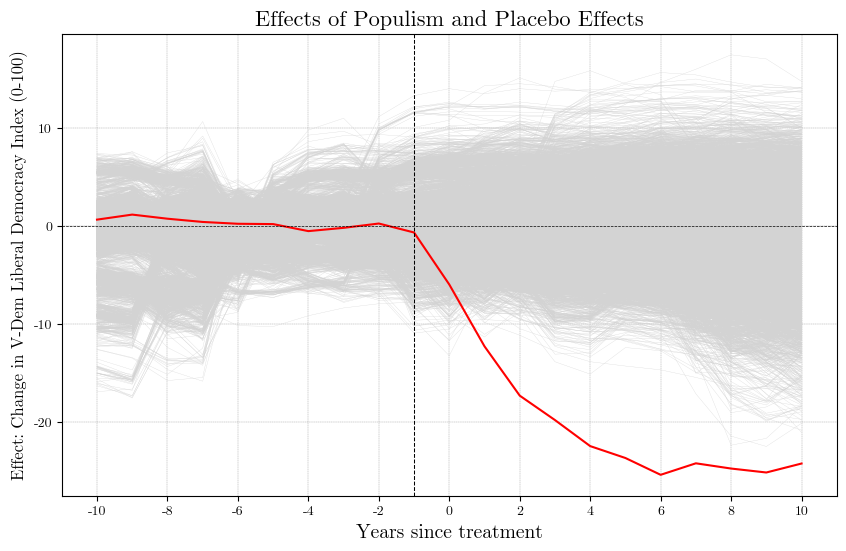

In [168]:
import matplotlib.pylab as plt

# Set the style
plt.rcParams['font.family'] = 'CMU Serif'
plt.rc('axes', unicode_minus=False)


# Group the data by 'id'
grouped_data = data.groupby('id')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each group and plot the time series line
for group_id, group_data in grouped_data:
    ax.plot(group_data['time'], group_data['gap'], color='lightgrey', alpha=1, linewidth=0.2)
    
ax.plot(data.loc[(data['avg'] == 'Populists')]['time'], data.loc[data['avg'] == 'Populists', 'gap'], color='red', label='Populists')

# Plot a thin dashed line on y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# Plot a vertical thin dashed line on x=0
ax.axvline(x=-1, color='black', linestyle='--', linewidth=0.75)

# Set the x-axis label
ax.set_xlabel('Years since treatment', size=14)

# Set the y-axis label
ax.set_ylabel('Effect: Change in V-Dem Liberal Democracy Index (0-100)', size=12)

# Set the title of the plot
ax.set_title('Effects of Populism and Placebo Effects', size=16)

#Edit grid options
ax.grid(color='grey', linestyle='--', linewidth=0.25)

# Set x ticks
ax.set_xticks(np.arange(-10, 11, 2))

# Show the plot
plt.show()


In [133]:
import matplotlib.pyplot as plt

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Use LaTeX-compatible font
plt.rcParams['font.family'] = 'serif'  # Use a serif font
plt.rcParams['font.serif'] = 'Computer Modern Roman'  # Specify the font name

# Your plotting code goes here
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
plt.xlabel(r'$\mathrm{xlabel}$')
plt.ylabel(r'$\mathrm{ylabel}$')
plt.title(r'$\mathrm{Title}$')

# Save or show the plot
plt.savefig('plot.pdf')  # Save as PDF for vector graphics
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found